In [71]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go


#for quick viz
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import random

In [72]:
df = pd.read_csv(r'C:\Users\ahmet\Downloads\Hafta_5_Scripts\auto_insurance_csv.csv')
df = df.drop(['_c39','Unnamed: 0'], axis = 1)
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df['police_report_available'] = df.police_report_available.fillna("MISSING")
df['policy_csl'] = df.policy_csl.fillna("MISSING")
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)
df['umbrella_limit'] = df.umbrella_limit.astype(str)
umbrealla = df['umbrella_limit'].unique()
for umb in umbrealla:
  if (umb != '0.0') & (umb != '9999'):
    df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')
    
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['age'] = df.age.fillna(9999)
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]

df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)
required_columns = ['incident_date','policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount','auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group']
df1 = df[required_columns]

<ipython-input-72-97d3854735d5>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')


In [73]:
# Verilerin 200'e 800 olarak validation ve train dataseti olarak ayırıyoruz.
df1_val = df1.sort_values(by='incident_date',ascending=False).head(200) 
df2 = df1.sort_values(by='incident_date',ascending=False).tail(800)

In [74]:
# "incident_date" üzerinden sıralayıp verileri böldük bu kolona artık gerek yok.
df1_val = df1_val.drop(["incident_date"],axis=1)
df2 = df2.drop(["incident_date"],axis=1)

In [75]:
# incident_location tüm değerler farklı olduğu için gruplamak mantıklı olabilirdi ama atıyorum.
df1_val = df1_val.drop(["incident_location"],axis=1)
df2 = df2.drop(["incident_location"],axis=1)

In [76]:
# Gruplamaya karar verdiğimiz değişkenlerin gruplanması ve kategorik veriye dönüştürülmesi.
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df2[col] = df2[col].astype('object')

# Tüm kategorik verileri tutuyoruz. OHE yapacağımız için önemli.
columns_to_encode = []
for col in df2.columns:
  if df2[col].dtype == 'object':
    columns_to_encode.append(col)

columns_to_encode

['policy_state',
 'policy_csl',
 'umbrella_limit',
 'insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_hobbies',
 'insured_relationship',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'incident_city',
 'property_damage',
 'police_report_available',
 'auto_make',
 'auto_model',
 'location_check',
 'age_group',
 'months_as_customer_groups',
 'policy_annual_premium_groups',
 'policy_deductable_group']

In [77]:
# Kolon isimlerinin sırasını almak için get_dummies yapıyorum.
# OneHotEncoding yapınca kolon isimleri kayboluyor.
dfohe = pd.get_dummies(df2, columns = columns_to_encode)
cl=[]
for _ in dfohe.columns:
    cl.append(_)
cl # İlk 10 kolon üzerinde get_dummies yapılmadı o kısmı ayrı tutmalıyım.

['insured_zip',
 'capital-gains',
 'capital-loss',
 'incident_hour_of_the_day',
 'number_of_vehicles_involved',
 'bodily_injuries',
 'witnesses',
 'total_claim_amount',
 'auto_year',
 'fraud_reported',
 'claim_day_of_policy',
 'policy_state_IL',
 'policy_state_IN',
 'policy_state_OH',
 'policy_csl_100/300',
 'policy_csl_250/500',
 'policy_csl_500/1000',
 'policy_csl_MISSING',
 'umbrella_limit_0.0',
 'umbrella_limit_9999',
 'umbrella_limit_other',
 'insured_sex_FEMALE',
 'insured_sex_MALE',
 'insured_education_level_Associate',
 'insured_education_level_College',
 'insured_education_level_High School',
 'insured_education_level_JD',
 'insured_education_level_MD',
 'insured_education_level_Masters',
 'insured_education_level_PhD',
 'insured_occupation_adm-clerical',
 'insured_occupation_armed-forces',
 'insured_occupation_craft-repair',
 'insured_occupation_exec-managerial',
 'insured_occupation_farming-fishing',
 'insured_occupation_handlers-cleaners',
 'insured_occupation_machine-op-in

In [78]:
df_10 = dfohe.iloc[:,:11] # ilk 10 değişken
cl1= cl[11:] # get_dummies ile oluşan tüm kolonların isimlerini tutuyorum.
cl1

['policy_state_IL',
 'policy_state_IN',
 'policy_state_OH',
 'policy_csl_100/300',
 'policy_csl_250/500',
 'policy_csl_500/1000',
 'policy_csl_MISSING',
 'umbrella_limit_0.0',
 'umbrella_limit_9999',
 'umbrella_limit_other',
 'insured_sex_FEMALE',
 'insured_sex_MALE',
 'insured_education_level_Associate',
 'insured_education_level_College',
 'insured_education_level_High School',
 'insured_education_level_JD',
 'insured_education_level_MD',
 'insured_education_level_Masters',
 'insured_education_level_PhD',
 'insured_occupation_adm-clerical',
 'insured_occupation_armed-forces',
 'insured_occupation_craft-repair',
 'insured_occupation_exec-managerial',
 'insured_occupation_farming-fishing',
 'insured_occupation_handlers-cleaners',
 'insured_occupation_machine-op-inspct',
 'insured_occupation_other-service',
 'insured_occupation_priv-house-serv',
 'insured_occupation_prof-specialty',
 'insured_occupation_protective-serv',
 'insured_occupation_sales',
 'insured_occupation_tech-support',
 

In [79]:
from sklearn.preprocessing import OneHotEncoder
# Validation kısmında hata almamak için "handle_unknown=ignore" olarak ayarladım.
ohe = OneHotEncoder(handle_unknown='ignore') 
df3=ohe.fit_transform(df2[columns_to_encode]).toarray()

In [80]:
# Bu işlemi yapmayınca indexler karıştığı için bazı değerlerimde NoNe oluyordu. O yüzden bu işlem önemli.
# Concat yapınca indexler çakışacağı için böyle yaptım.
df_10.reset_index(drop=True, inplace=True)

In [81]:
# OneHotEncoding yapılmış verimiz ile öncesinde ayırdığım 10 nümerik veriyi birleştirdim.
df4=pd.DataFrame(df3, columns=cl1)
df5 = pd.concat([df_10,df4], axis=1)
df5.head(10) # DF5 Train datamızın ohe yapılmış hali.

,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,fraud_reported,...,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
0,446755,0,-46200,9,1,2,3,6560,2003,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,475891,0,0,6,1,1,3,6000,2000,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,603948,47200,-69700,12,3,2,3,36300,2013,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,462525,26500,0,23,3,0,3,55200,1998,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,471366,0,-31700,0,1,2,1,48290,1995,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,604328,0,-47400,7,1,0,1,3190,2015,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,438546,0,-54600,13,1,1,2,72120,2009,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,431354,0,0,21,3,1,3,48070,2014,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,476737,0,-40900,8,1,0,1,70290,2008,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,437470,0,0,17,3,2,3,42500,2000,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [82]:
# Train datamızın bölünmesi
features = []
for col in df5.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = df5[features]
y = df5[target]

In [83]:
# X verimizi scale ediyoruz.
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

In [84]:
X[:20]

array([[-0.76745023, -0.90867046, -0.68250677, ..., -0.71374643,
        -0.67616189,  1.36652242],
       [-0.36042417, -0.90867046,  0.96145549, ...,  1.4010578 ,
        -0.67616189, -0.73178456],
       [ 1.42851515,  0.79450874, -1.51872134, ..., -0.71374643,
        -0.67616189,  1.36652242],
       ...,
       [-0.31773225, -0.90867046,  0.96145549, ...,  1.4010578 ,
        -0.67616189, -0.73178456],
       [-0.98959906, -0.90867046, -0.53661401, ..., -0.71374643,
         1.47893576, -0.73178456],
       [-0.3395951 , -0.90867046, -1.09171815, ..., -0.71374643,
         1.47893576, -0.73178456]])

C:\Users\ahmet\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

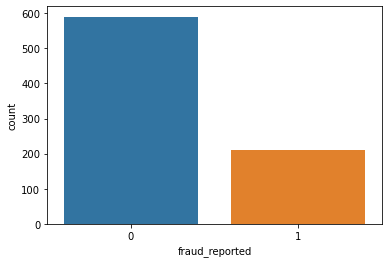

In [85]:
# Görüldüğü gibi şu an datamız imbalance halde.
chck = pd.DataFrame()
chck['fraud_reported'] = y

sns.countplot(chck['fraud_reported'])

In [86]:
# Oversampling işlemleri

oversample = SMOTE(random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state = 10)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

C:\Users\ahmet\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fraud_reported', ylabel='count'>

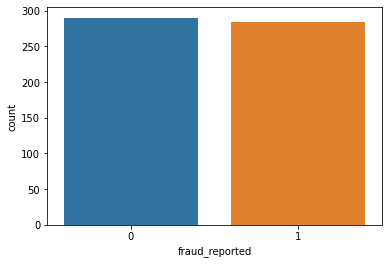

In [87]:
# Sentetik veri üreterek veriyi dengeli hale getirdik.
chck = pd.DataFrame()
chck['fraud_reported'] = y_train

sns.countplot(chck['fraud_reported'])

## Modelleme

### RandomForestClassifier

87.39837398373984

              precision    recall  f1-score   support

           0       0.89      0.84      0.87       120
           1       0.86      0.90      0.88       126

    accuracy                           0.87       246
   macro avg       0.88      0.87      0.87       246
weighted avg       0.88      0.87      0.87       246



<AxesSubplot:>

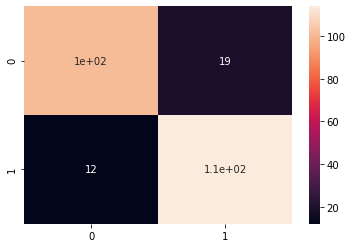

In [88]:
# Modelin eğitilmesi ve sonuçları
rfc = RandomForestClassifier(random_state = 12)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

In [89]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [100, 300, 500, 700, 900]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 3, 5, 8, 10]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=13, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

{'n_estimators': [100, 300, 500, 700, 900], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 5, 8, 10, None], 'min_samples_split': [2, 5, 7, 10], 'min_samples_leaf': [1, 2, 4, 6, 8], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 5, 8, 10, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 7, 10],
                                        'n_estimators': [100, 300, 500, 700,
                                                         900]},
                   random_state=13, verbose=2)

In [90]:
# Optimum parametreler
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 5,
 'bootstrap': False}

89.43089430894308

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       120
           1       0.85      0.96      0.90       126

    accuracy                           0.89       246
   macro avg       0.90      0.89      0.89       246
weighted avg       0.90      0.89      0.89       246



<AxesSubplot:>

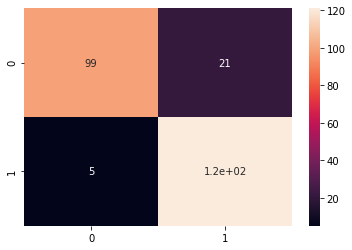

In [92]:
# Elde ettiğimiz optimum parametreler üzerine modelin tekrar kurulması
rf2 = RandomForestClassifier(n_estimators=700,min_samples_split=5,min_samples_leaf=1,max_features='sqrt'
                            ,max_depth=5,bootstrap='False', random_state=5)
rf2.fit(X_train, y_train)

preds = rf2.predict(X_test)

score = rf2.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

#### Validation

In [93]:
# Train datamız için yaptığımız ohe işlemlerini en başta ayırdığım validation datası için yapıyorum.
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df1_val[col] = df1_val[col].astype('object')

columns_to_encode = []
for col in df1_val.columns:
  if df1_val[col].dtype == 'object':
    columns_to_encode.append(col)

# Train datamız için oluşturduğumuz ohe objesini uyguluyoruz. (sadece transform)
df2_val = pd.DataFrame(ohe.transform(df1_val[columns_to_encode]).toarray(), columns=cl1)

In [94]:
df2_val.head()

,policy_state_IL,policy_state_IN,policy_state_OH,policy_csl_100/300,policy_csl_250/500,policy_csl_500/1000,policy_csl_MISSING,umbrella_limit_0.0,umbrella_limit_9999,umbrella_limit_other,...,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [95]:
cl0 = cl[:11] # İlk 10 nümerik kolonumuz
df_val_num = pd.DataFrame(df1_val, columns=cl0)

In [96]:
# Bunu yapmadan concat işlemi yapınca indexler çakıştığı için çok fazla NoNe değer alıyorum.
df_val_num.reset_index(drop=True, inplace=True)

In [97]:
# ilk 10 nümeric kolonlarımız ile ohe yaptığımız kolonları birleştiriyorum.
df3_val = pd.concat([df_val_num,df2_val], axis=1)
df3_val.head() # Validation datamız hazır.
# En önemlisi validatino datamızın kolon sayısı ile train datamızın kolon sayısı aynı. Hatayı çözdük.
# handle_unknown=ignore sayesinde.

,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,fraud_reported,...,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
0,441533,57100,0,2,4,0,2,38640,1997,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,472895,0,0,18,3,1,0,42930,2005,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,436364,0,-67000,2,4,0,2,72800,1998,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,479824,0,0,18,3,0,3,34160,2005,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,448294,0,-48800,4,1,2,2,51600,2011,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [98]:
# Validation datası için ayırma işlemi
features = []
for col in df3_val.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X_val = df3_val[features]
y_val = df3_val[target]

In [99]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_val = sc.fit_transform(X_val)

70.0

              precision    recall  f1-score   support

           0       0.94      0.67      0.79       163
           1       0.36      0.81      0.50        37

    accuracy                           0.70       200
   macro avg       0.65      0.74      0.64       200
weighted avg       0.83      0.70      0.73       200



<AxesSubplot:>

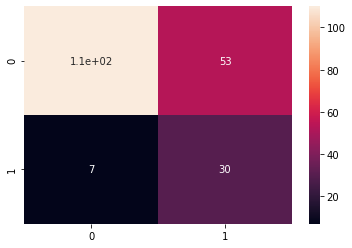

In [100]:
# Önceden eğittiğimiz modele validation datamızı veriyoruz.
preds = rfc.predict(X_val)
score = rfc.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

58.5

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       163
           1       0.44      0.81      0.57        37

    accuracy                           0.78       200
   macro avg       0.69      0.79      0.71       200
weighted avg       0.85      0.78      0.80       200



<AxesSubplot:>

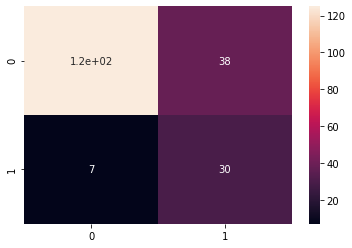

In [106]:
# Hyperparameter Tuning yapılmış modele threshold belirleyerek validation datasını uyguladım.
preds = rf2.predict_proba(X_val)[:,1]
y_pred = [1 if i>0.58 else 0 for i in preds]
score = rf2.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
sns
sns.heatmap(cm, annot=True)

### CatBoostClassifier

Learning rate set to 0.008128
0:	learn: 0.6847450	total: 435ms	remaining: 7m 15s
1:	learn: 0.6764848	total: 443ms	remaining: 3m 41s
2:	learn: 0.6686409	total: 453ms	remaining: 2m 30s
3:	learn: 0.6608201	total: 459ms	remaining: 1m 54s
4:	learn: 0.6544276	total: 468ms	remaining: 1m 33s
5:	learn: 0.6464514	total: 476ms	remaining: 1m 18s
6:	learn: 0.6387787	total: 486ms	remaining: 1m 8s
7:	learn: 0.6306806	total: 492ms	remaining: 1m 1s
8:	learn: 0.6233711	total: 502ms	remaining: 55.3s
9:	learn: 0.6167745	total: 508ms	remaining: 50.3s
10:	learn: 0.6094575	total: 518ms	remaining: 46.6s
11:	learn: 0.6031845	total: 524ms	remaining: 43.2s
12:	learn: 0.5958192	total: 861ms	remaining: 1m 5s
13:	learn: 0.5897627	total: 870ms	remaining: 1m 1s
14:	learn: 0.5842588	total: 881ms	remaining: 57.8s
15:	learn: 0.5782839	total: 887ms	remaining: 54.6s
16:	learn: 0.5711112	total: 901ms	remaining: 52.1s
17:	learn: 0.5649195	total: 917ms	remaining: 50s
18:	learn: 0.5601628	total: 923ms	remaining: 47.7s
19:	lea

177:	learn: 0.2319654	total: 2.33s	remaining: 10.8s
178:	learn: 0.2311879	total: 2.34s	remaining: 10.7s
179:	learn: 0.2307776	total: 2.35s	remaining: 10.7s
180:	learn: 0.2303317	total: 2.35s	remaining: 10.7s
181:	learn: 0.2295598	total: 2.36s	remaining: 10.6s
182:	learn: 0.2290197	total: 2.37s	remaining: 10.6s
183:	learn: 0.2285098	total: 2.38s	remaining: 10.5s
184:	learn: 0.2281140	total: 2.38s	remaining: 10.5s
185:	learn: 0.2272796	total: 2.39s	remaining: 10.5s
186:	learn: 0.2266221	total: 2.4s	remaining: 10.4s
187:	learn: 0.2257154	total: 2.41s	remaining: 10.4s
188:	learn: 0.2248824	total: 2.42s	remaining: 10.4s
189:	learn: 0.2242378	total: 2.42s	remaining: 10.3s
190:	learn: 0.2239569	total: 2.43s	remaining: 10.3s
191:	learn: 0.2230943	total: 2.44s	remaining: 10.3s
192:	learn: 0.2225480	total: 2.45s	remaining: 10.2s
193:	learn: 0.2220746	total: 2.45s	remaining: 10.2s
194:	learn: 0.2214484	total: 2.46s	remaining: 10.2s
195:	learn: 0.2210235	total: 2.47s	remaining: 10.1s
196:	learn: 0

356:	learn: 0.1549960	total: 3.79s	remaining: 6.82s
357:	learn: 0.1545914	total: 3.8s	remaining: 6.81s
358:	learn: 0.1545240	total: 3.8s	remaining: 6.79s
359:	learn: 0.1542266	total: 3.81s	remaining: 6.78s
360:	learn: 0.1539483	total: 3.82s	remaining: 6.76s
361:	learn: 0.1537214	total: 3.83s	remaining: 6.75s
362:	learn: 0.1534643	total: 3.83s	remaining: 6.73s
363:	learn: 0.1532210	total: 3.85s	remaining: 6.72s
364:	learn: 0.1530193	total: 3.86s	remaining: 6.71s
365:	learn: 0.1526828	total: 3.86s	remaining: 6.69s
366:	learn: 0.1523986	total: 3.87s	remaining: 6.68s
367:	learn: 0.1522230	total: 3.88s	remaining: 6.66s
368:	learn: 0.1517404	total: 3.89s	remaining: 6.65s
369:	learn: 0.1514861	total: 3.89s	remaining: 6.63s
370:	learn: 0.1511718	total: 3.9s	remaining: 6.61s
371:	learn: 0.1508682	total: 3.91s	remaining: 6.6s
372:	learn: 0.1505925	total: 3.92s	remaining: 6.58s
373:	learn: 0.1503665	total: 3.93s	remaining: 6.57s
374:	learn: 0.1502143	total: 3.94s	remaining: 6.56s
375:	learn: 0.14

523:	learn: 0.1159312	total: 5.26s	remaining: 4.78s
524:	learn: 0.1157398	total: 5.27s	remaining: 4.77s
525:	learn: 0.1156973	total: 5.28s	remaining: 4.76s
526:	learn: 0.1154786	total: 5.29s	remaining: 4.75s
527:	learn: 0.1152871	total: 5.3s	remaining: 4.73s
528:	learn: 0.1151284	total: 5.3s	remaining: 4.72s
529:	learn: 0.1148940	total: 5.31s	remaining: 4.71s
530:	learn: 0.1146661	total: 5.32s	remaining: 4.7s
531:	learn: 0.1144786	total: 5.33s	remaining: 4.69s
532:	learn: 0.1143497	total: 5.34s	remaining: 4.67s
533:	learn: 0.1141741	total: 5.34s	remaining: 4.66s
534:	learn: 0.1139327	total: 5.35s	remaining: 4.65s
535:	learn: 0.1137682	total: 5.36s	remaining: 4.64s
536:	learn: 0.1136100	total: 5.37s	remaining: 4.63s
537:	learn: 0.1133229	total: 5.37s	remaining: 4.61s
538:	learn: 0.1131355	total: 5.38s	remaining: 4.6s
539:	learn: 0.1129669	total: 5.39s	remaining: 4.59s
540:	learn: 0.1128373	total: 5.39s	remaining: 4.58s
541:	learn: 0.1126848	total: 5.4s	remaining: 4.57s
542:	learn: 0.112

694:	learn: 0.0865952	total: 8.19s	remaining: 3.59s
695:	learn: 0.0863951	total: 8.21s	remaining: 3.58s
696:	learn: 0.0862608	total: 8.23s	remaining: 3.58s
697:	learn: 0.0861389	total: 8.27s	remaining: 3.58s
698:	learn: 0.0860102	total: 8.29s	remaining: 3.57s
699:	learn: 0.0859417	total: 8.31s	remaining: 3.56s
700:	learn: 0.0858720	total: 8.34s	remaining: 3.56s
701:	learn: 0.0857869	total: 8.37s	remaining: 3.55s
702:	learn: 0.0856343	total: 8.39s	remaining: 3.54s
703:	learn: 0.0855291	total: 8.42s	remaining: 3.54s
704:	learn: 0.0854625	total: 8.43s	remaining: 3.53s
705:	learn: 0.0853427	total: 8.47s	remaining: 3.53s
706:	learn: 0.0852433	total: 8.49s	remaining: 3.52s
707:	learn: 0.0850747	total: 8.51s	remaining: 3.51s
708:	learn: 0.0849924	total: 8.53s	remaining: 3.5s
709:	learn: 0.0849330	total: 8.55s	remaining: 3.49s
710:	learn: 0.0847908	total: 8.58s	remaining: 3.49s
711:	learn: 0.0847650	total: 8.59s	remaining: 3.48s
712:	learn: 0.0846295	total: 8.6s	remaining: 3.46s
713:	learn: 0.

871:	learn: 0.0662301	total: 10.6s	remaining: 1.55s
872:	learn: 0.0661582	total: 10.6s	remaining: 1.54s
873:	learn: 0.0660967	total: 10.6s	remaining: 1.53s
874:	learn: 0.0659834	total: 10.6s	remaining: 1.52s
875:	learn: 0.0659523	total: 10.7s	remaining: 1.51s
876:	learn: 0.0659238	total: 10.7s	remaining: 1.5s
877:	learn: 0.0658413	total: 10.7s	remaining: 1.48s
878:	learn: 0.0657873	total: 10.7s	remaining: 1.47s
879:	learn: 0.0656947	total: 10.7s	remaining: 1.46s
880:	learn: 0.0656490	total: 10.7s	remaining: 1.44s
881:	learn: 0.0655409	total: 10.7s	remaining: 1.43s
882:	learn: 0.0653259	total: 10.7s	remaining: 1.42s
883:	learn: 0.0652214	total: 10.7s	remaining: 1.41s
884:	learn: 0.0650539	total: 10.7s	remaining: 1.39s
885:	learn: 0.0649530	total: 10.7s	remaining: 1.38s
886:	learn: 0.0649226	total: 10.8s	remaining: 1.37s
887:	learn: 0.0648777	total: 10.8s	remaining: 1.36s
888:	learn: 0.0648397	total: 10.8s	remaining: 1.35s
889:	learn: 0.0647637	total: 10.8s	remaining: 1.33s
890:	learn: 0

<AxesSubplot:>

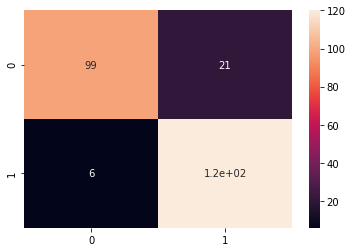

In [107]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(random_state=1).fit(X_train,y_train)

preds = cat_model.predict(X_test)

score = cat_model.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

In [108]:
from sklearn.model_selection import RandomizedSearchCV

iterations = [200, 500, 750]
learning_rate = [0.01, 0.05, 0.1, 0.15]
depth = [3,5,8]
cat_model_params = {'iterations': iterations,
               'learning_rate': learning_rate,
               'depth': depth
               }
print(cat_model_params)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
cat = CatBoostClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
cat_random = RandomizedSearchCV(estimator = cat, param_distributions = cat_model_params, n_iter = 100, cv = 3, verbose=2, random_state=13, n_jobs = -1)
# Fit the random search model
cat_random.fit(X_train, y_train)

{'iterations': [200, 500, 750], 'learning_rate': [0.01, 0.05, 0.1, 0.15], 'depth': [3, 5, 8]}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\ahmet\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 0.5864740	total: 33ms	remaining: 6.57s
1:	learn: 0.4775641	total: 66.1ms	remaining: 6.54s
2:	learn: 0.4020440	total: 129ms	remaining: 8.48s
3:	learn: 0.3482874	total: 156ms	remaining: 7.67s
4:	learn: 0.3122797	total: 189ms	remaining: 7.37s
5:	learn: 0.2712424	total: 215ms	remaining: 6.94s
6:	learn: 0.2548285	total: 245ms	remaining: 6.76s
7:	learn: 0.2357225	total: 274ms	remaining: 6.57s
8:	learn: 0.2152547	total: 306ms	remaining: 6.49s
9:	learn: 0.2016965	total: 331ms	remaining: 6.29s
10:	learn: 0.1905253	total: 368ms	remaining: 6.32s
11:	learn: 0.1747756	total: 394ms	remaining: 6.17s
12:	learn: 0.1668160	total: 423ms	remaining: 6.09s
13:	learn: 0.1586447	total: 453ms	remaining: 6.02s
14:	learn: 0.1519530	total: 478ms	remaining: 5.89s
15:	learn: 0.1447113	total: 506ms	remaining: 5.82s
16:	learn: 0.1362245	total: 540ms	remaining: 5.81s
17:	learn: 0.1303473	total: 568ms	remaining: 5.75s
18:	learn: 0.1245225	total: 594ms	remaining: 5.66s
19:	learn: 0.1183033	total: 626ms	remaini

167:	learn: 0.0060628	total: 4.84s	remaining: 921ms
168:	learn: 0.0060460	total: 4.87s	remaining: 893ms
169:	learn: 0.0060325	total: 4.89s	remaining: 864ms
170:	learn: 0.0059681	total: 4.92s	remaining: 834ms
171:	learn: 0.0059366	total: 4.94s	remaining: 804ms
172:	learn: 0.0059218	total: 4.97s	remaining: 775ms
173:	learn: 0.0059039	total: 5s	remaining: 746ms
174:	learn: 0.0058793	total: 5.03s	remaining: 718ms
175:	learn: 0.0058056	total: 5.05s	remaining: 689ms
176:	learn: 0.0057487	total: 5.08s	remaining: 660ms
177:	learn: 0.0057393	total: 5.11s	remaining: 631ms
178:	learn: 0.0057203	total: 5.13s	remaining: 602ms
179:	learn: 0.0057062	total: 5.16s	remaining: 573ms
180:	learn: 0.0057061	total: 5.18s	remaining: 544ms
181:	learn: 0.0056941	total: 5.21s	remaining: 515ms
182:	learn: 0.0056846	total: 5.23s	remaining: 486ms
183:	learn: 0.0056020	total: 5.26s	remaining: 458ms
184:	learn: 0.0056020	total: 5.29s	remaining: 429ms
185:	learn: 0.0055753	total: 5.31s	remaining: 400ms
186:	learn: 0.0

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000169A4B53700>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'depth': [3, 5, 8],
                                        'iterations': [200, 500, 750],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15]},
                   random_state=13, verbose=2)

In [109]:
cat_random.best_params_

{'learning_rate': 0.15, 'iterations': 200, 'depth': 8}

0:	learn: 0.5625537	total: 31.7ms	remaining: 6.31s
1:	learn: 0.4634282	total: 52.2ms	remaining: 5.17s
2:	learn: 0.3902102	total: 73.5ms	remaining: 4.83s
3:	learn: 0.3387261	total: 96.3ms	remaining: 4.72s
4:	learn: 0.2995405	total: 116ms	remaining: 4.52s
5:	learn: 0.2691580	total: 137ms	remaining: 4.42s
6:	learn: 0.2403953	total: 156ms	remaining: 4.31s
7:	learn: 0.2239561	total: 177ms	remaining: 4.26s
8:	learn: 0.2071936	total: 197ms	remaining: 4.17s
9:	learn: 0.1897377	total: 217ms	remaining: 4.13s
10:	learn: 0.1794191	total: 248ms	remaining: 4.26s
11:	learn: 0.1680351	total: 268ms	remaining: 4.2s
12:	learn: 0.1606157	total: 288ms	remaining: 4.14s
13:	learn: 0.1499800	total: 311ms	remaining: 4.14s
14:	learn: 0.1455134	total: 331ms	remaining: 4.09s
15:	learn: 0.1385321	total: 351ms	remaining: 4.04s
16:	learn: 0.1305895	total: 373ms	remaining: 4.01s
17:	learn: 0.1253203	total: 395ms	remaining: 4s
18:	learn: 0.1205550	total: 426ms	remaining: 4.06s
19:	learn: 0.1162222	total: 447ms	remaini

168:	learn: 0.0062922	total: 4.19s	remaining: 769ms
169:	learn: 0.0062322	total: 4.22s	remaining: 744ms
170:	learn: 0.0062277	total: 4.25s	remaining: 720ms
171:	learn: 0.0061560	total: 4.27s	remaining: 696ms
172:	learn: 0.0061560	total: 4.3s	remaining: 671ms
173:	learn: 0.0061288	total: 4.33s	remaining: 647ms
174:	learn: 0.0060175	total: 4.36s	remaining: 623ms
175:	learn: 0.0060020	total: 4.39s	remaining: 599ms
176:	learn: 0.0059565	total: 4.42s	remaining: 574ms
177:	learn: 0.0058518	total: 4.44s	remaining: 549ms
178:	learn: 0.0058338	total: 4.47s	remaining: 524ms
179:	learn: 0.0058289	total: 4.49s	remaining: 499ms
180:	learn: 0.0057832	total: 4.52s	remaining: 474ms
181:	learn: 0.0057832	total: 4.54s	remaining: 450ms
182:	learn: 0.0057413	total: 4.57s	remaining: 425ms
183:	learn: 0.0057254	total: 4.6s	remaining: 400ms
184:	learn: 0.0056835	total: 4.64s	remaining: 376ms
185:	learn: 0.0056835	total: 4.66s	remaining: 351ms
186:	learn: 0.0056239	total: 4.69s	remaining: 326ms
187:	learn: 0.

<AxesSubplot:>

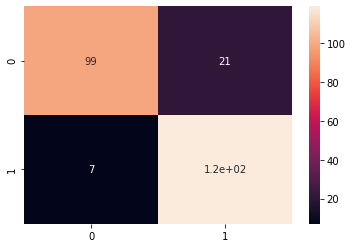

In [110]:
from catboost import CatBoostClassifier

cat_model_new = CatBoostClassifier(learning_rate=0.15,iterations=200,depth=8,random_state=5).fit(X_train,y_train)

preds = cat_model_new.predict(X_test)

score = cat_model_new.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

#### Validation

79.0

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       163
           1       0.46      0.81      0.59        37

    accuracy                           0.79       200
   macro avg       0.70      0.80      0.72       200
weighted avg       0.86      0.79      0.81       200



<AxesSubplot:>

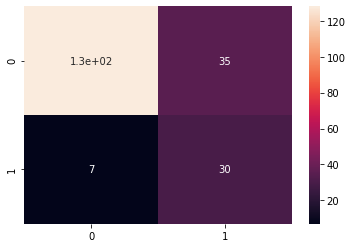

In [112]:
# Önceden eğittiğimiz modele validation datamızı veriyoruz.
preds = cat_model.predict(X_val)
score = cat_model.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

76.5

              precision    recall  f1-score   support

           0       0.95      0.78      0.86       163
           1       0.45      0.81      0.58        37

    accuracy                           0.79       200
   macro avg       0.70      0.79      0.72       200
weighted avg       0.86      0.79      0.80       200



<AxesSubplot:>

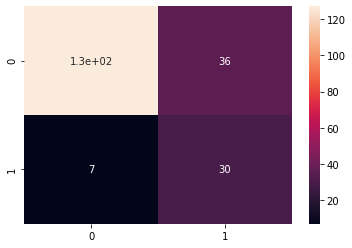

In [120]:
# Hyperparameter Tuning yapılmış modele threshold belirleyerek validation datasını uyguladım.
preds = cat_model_new.predict_proba(X_val)[:,1]
y_pred = [1 if i>0.6 else 0 for i in preds]
score = cat_model_new.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
sns
sns.heatmap(cm, annot=True)

### SVC

90.2439024390244

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       120
           1       0.87      0.95      0.91       126

    accuracy                           0.90       246
   macro avg       0.91      0.90      0.90       246
weighted avg       0.91      0.90      0.90       246



<AxesSubplot:>

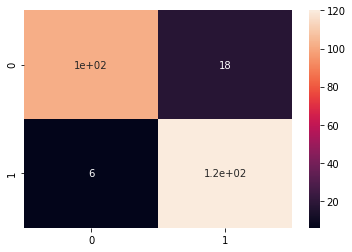

In [121]:
from sklearn.svm import SVC

svc_model = SVC().fit(X_train, y_train)

preds = svc_model.predict(X_test)

score = svc_model.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

In [141]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
C = [0.1,1, 10, 100]
kernel = ["linear", "poly", "rbf", "sigmoid"]
gamma = [1,0.1,0.01,0.001]
svc_model_params = {'C': C, "kernel": kernel, "gamma":gamma}
print(svc_model_params)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
svc = SVC()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = svc_model_params, n_iter = 100, cv = 3, verbose=2, random_state=8, n_jobs = -1)
# Fit the random search model
svc_random.fit(X_train, y_train)

{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1, 0.1, 0.01, 0.001]}
Fitting 3 folds for each of 64 candidates, totalling 192 fits


C:\Users\ahmet\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [1, 0.1, 0.01, 0.001],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=8, verbose=2)

In [142]:
svc_random.best_params_

{'kernel': 'rbf', 'gamma': 0.001, 'C': 10}

89.02439024390245

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       120
           1       0.86      0.94      0.90       126

    accuracy                           0.89       246
   macro avg       0.90      0.89      0.89       246
weighted avg       0.89      0.89      0.89       246



<AxesSubplot:>

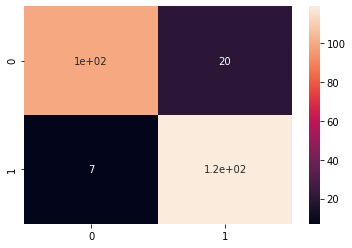

In [143]:
from sklearn.svm import SVC

svc_model_new = SVC(kernel="rbf", gamma=0.001, C=10, random_state=5,probability=True).fit(X_train, y_train)

preds = svc_model_new.predict(X_test)

score = svc_model_new.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

#### Validation

79.0

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       163
           1       0.45      0.62      0.52        37

    accuracy                           0.79       200
   macro avg       0.68      0.72      0.69       200
weighted avg       0.82      0.79      0.80       200



<AxesSubplot:>

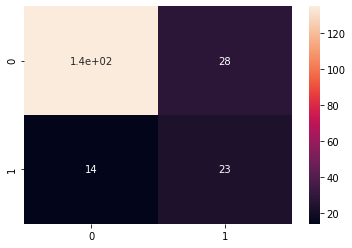

In [144]:
# Önceden eğittiğimiz modele validation datamızı veriyoruz.
preds = svc_model.predict(X_val)
score = svc_model.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

77.5

              precision    recall  f1-score   support

           0       0.93      0.79      0.85       163
           1       0.44      0.76      0.56        37

    accuracy                           0.78       200
   macro avg       0.69      0.77      0.71       200
weighted avg       0.84      0.78      0.80       200



<AxesSubplot:>

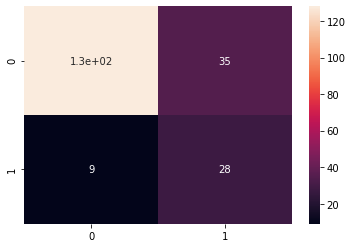

In [145]:
# Hyperparameter Tuning yapılmış modele threshold belirleyerek validation datasını uyguladım.
preds = svc_model_new.predict_proba(X_val)[:,1]
y_pred = [1 if i>0.4 else 0 for i in preds]
score = svc_model_new.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
sns
sns.heatmap(cm, annot=True)

**Bir çok farklı model denedim fakat başarısız olanları eklemedim. 3 farklı modelde validation datalarının sonuçları aşağı yukarı aynı çıktı. İlerleyen günlerde daha başarılı sonuçlar için verinin keşifsel analizi kısmından başlayarak daha detaylı bir yol izlemeyi düşünüyorum.**